In [95]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import numpy as np

from dotenv import load_dotenv
import os

load_dotenv()

import h3

# Open df

In [96]:
# h3
LOCAL_FILE_PATH = os.getenv('LOCAL_FILE_PATH')
h3_index = gpd.read_file(f'{LOCAL_FILE_PATH}h3_index_preprocessed_EN.gpkg')

print(h3_index.shape)
h3_index.head(3)

(18905, 22)


h3_index  h3_resolution     nm_city nm_state_abbrev  \
0  89a81140003ffff              9  indaiatuba              SP   
1  89a81140007ffff              9  indaiatuba              SP   
2  89a8114000bffff              9  indaiatuba              SP   

   nr_distance_urban_growth_2020_2022_m  nr_distance_road_m  \
0                                 517.0                 0.0   
1                                 252.0                 0.0   
2                                 503.0                 0.0   

   nr_distance_highways_m  nr_distance_urban_area_m  nr_poi_positive  \
0                   20298                       0.0               32   
1                   20465                       0.0               24   
2                   19947                       0.0               30   

   nr_poi_negative  fl_construction_restriction  nr_population_ibge22  \
0                2                            0                 648.0   
1                1                            0                 790.0   
2                0                            0                 761.0   

   nr_households_ibge22  rt_people_households_ibge22  \
0                 296.0                     2.189189   
1                 276.0                     2.862319   
2                 360.0                     2.113889   

   nr_monthly_income_household  nr_minimum_wage_household  \
0                      8041.04                       5.69   
1                     10893.25                       7.71   
2                      8690.00                       6.15   

  ds_minimum_wage_range_household  nr_poor_urban_communities  \
0    3. more than 5 minimum wages                          0   
1    3. more than 5 minimum wages                          0   
2    3. more than 5 minimum wages                          0   

   fl_contaminated_area  nr_contaminated_areas  nr_slope  \
0                     0                      0      23.0   
1                     0                      0      17.0   
2                     1                      1       5.0   

                                            geometry  
0  POLYGON ((-47.21295 -23.08044, -47.21189 -23.0...  
1  POLYGON ((-47.21595 -23.07875, -47.21489 -23.0...  
2  POLYGON ((-47.20986 -23.07905, -47.20879 -23.0...

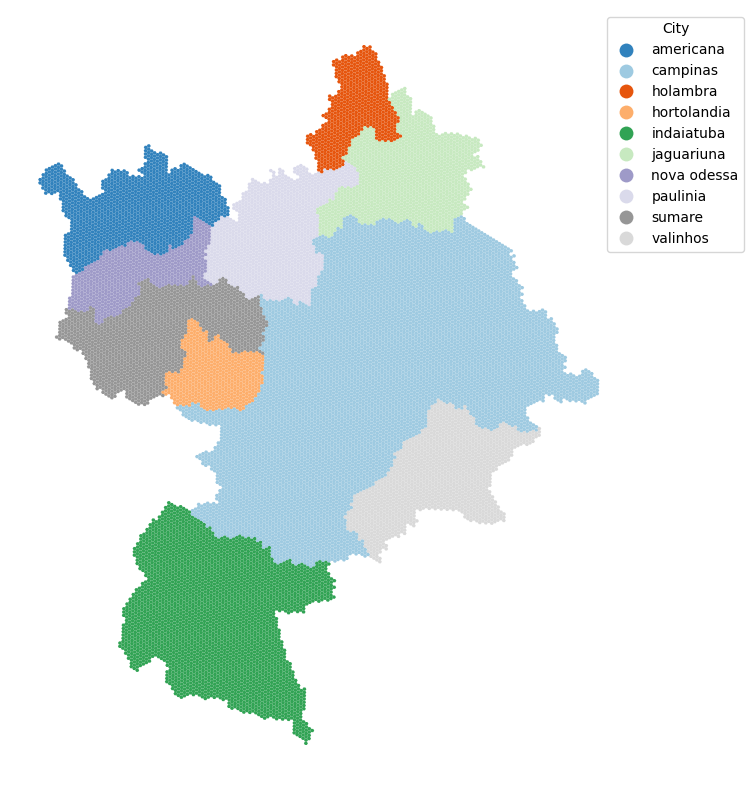

In [97]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
h3_index.plot(column='nm_city', ax=ax, legend=True, cmap='tab20c',
              legend_kwds={'bbox_to_anchor': (1.2, 1), 'title': 'City'})
ax.set_axis_off()

In [98]:
# cities boundaries
cities_boundaries = gpd.read_file(f'{LOCAL_FILE_PATH}ibge_municipios.gpkg')
list_cities = h3_index['nm_city'].unique()
cities_boundaries = cities_boundaries[cities_boundaries['nm_municipio'].isin(list_cities)]
cities_boundaries.head(3)

gid_municipio nm_municipio  \
0           3387    americana   
1           3483     campinas   
3           3576   indaiatuba   

                                            geometry  
0  MULTIPOLYGON (((-47.23018 -22.74333, -47.23055...  
1  MULTIPOLYGON (((-46.99878 -22.93474, -46.99915...  
3  MULTIPOLYGON (((-47.22945 -23.18144, -47.22949...

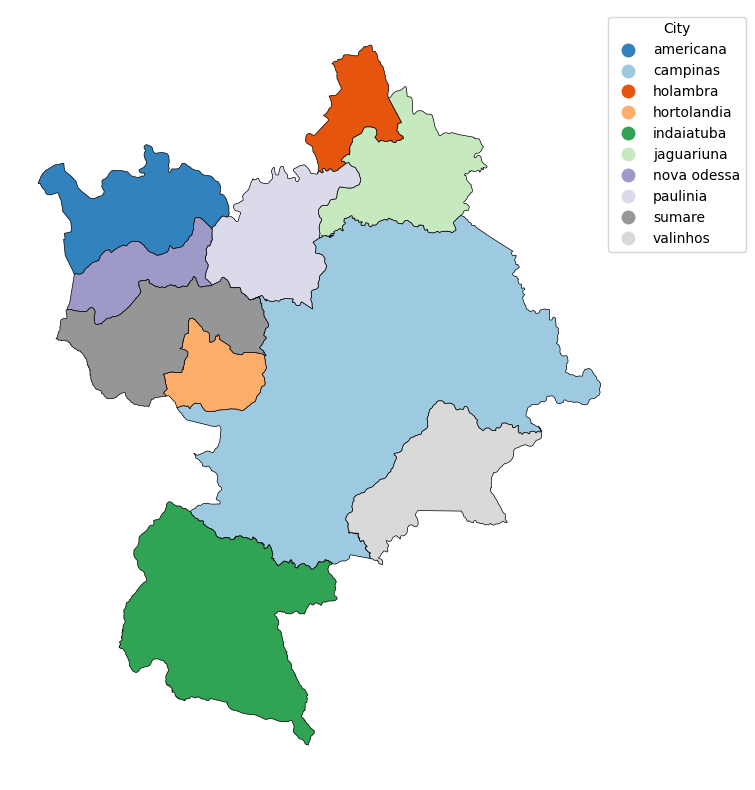

In [99]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
cities_boundaries.plot(column='nm_municipio', ax=ax, legend=True, cmap='tab20c',
                       linewidth=0.5, edgecolor='black',
                       legend_kwds={'bbox_to_anchor': (1.2, 1), 'title': 'City'})
ax.set_axis_off()

# Create Index - MPI - Mazziotta-Pareto
- From paper: Developing the urban comfort index: Advancing liveability analytics with a multidimensional approach and explainable artificial intelligence (Binyu Lei, Pengyuan Liu, Xiucheng Liang, Yingwei Yan, Filip Biljecki)

"A variety of indicators outlined in Section 3.1 contribute to the urban comfort index, with features having either a positive or negative impact on urban comfort. For example, higher levels of noise, air pollutants, and unfavourable human perceptions of the surroundings are generally less desirable. Reviewing the methods used in socio-economic and policymaking domains, the Mazziotta-Pareto index (MPI) is widely accepted as a composite instrument"

![Figure 1: MPI formula](fig1.png)

"where 𝑀𝑍𝑖 is the mean of the standardised values for unit 𝑖, 𝑆𝑍𝑖 is the standard deviation of the standardised values for unit 𝑖, and 𝑐𝑣𝑍𝑖 is the coefficient of variation. It enables the aggregation of multiple indicators at spatial units and summarises their impact into a single index (Mazziotta & Pareto, 2016). Compared to other measurements, a key aspect of the MPI method is the penalisation of imbalances among positive and negative indicators, using a range of standard deviations to match the polarity of indicator values."

![Figure 2: MPI formula](fig2.png)

"where 𝑥𝑖𝑗 is the value of the 𝑗th indicator for the 𝑖th unit, 𝑀𝑥𝑗 is the mean of the 𝑗th indicator across all units, and 𝑆𝑥𝑗 is the standard deviation of the 𝑗th indicator. Data-wise, the MPI method reduces the dimensionality of the data while preserving essential information, helping enhance efficiency and mitigate the impact of outliers. In our research, we generate urban comfort scores by applying the MPI method to the included indicators. Following the formula structure, the 100 is a constant used as the baseline score for standardising the values (Mazziotta & Pareto, 2016), making the index more interpretable and comparable. Therefore, we define in this work, that urban areas scoring above 100 are considered more comfortable for living and activities, while areas scoring below 100 are regarded as having less urban comfort."


In [100]:
# create a function to calculate the Mazziotta–Pareto index

def compute_mpi(data, polarity):
    """
    Compute the Mazziotta-Pareto Index (MPI) for a given dataset.

    Parameters:
        data (pd.DataFrame): A DataFrame where rows represent units and columns represent indicators.
        polarity (list): A list of '+' or '-' indicating the polarity of each indicator.

    Returns:
        pd.Series: A Series containing the MPI for each unit.
    """
    # Step 1: Standardize the indicators
    standardized_data = pd.DataFrame()
    for col, pol in zip(data.columns, polarity):
        mean = data[col].mean()
        std = data[col].std()
        if pol == '+':
            standardized_data[col] = 100 + ((data[col] - mean) / std) * 10
        elif pol == '-':
            standardized_data[col] = 100 - ((data[col] - mean) / std) * 10
        else:
            raise ValueError("Polarity must be '+' or '-'")

    # Step 2: Compute MZ_i, SZ_i, and cvZ_i for each unit
    MZ_i = standardized_data.mean(axis=1)
    SZ_i = standardized_data.std(axis=1)
    cvZ_i = SZ_i / MZ_i

    # Step 3: Compute MPI
    MPI = MZ_i - SZ_i * cvZ_i

    return MPI, standardized_data


## Example of application

In [101]:
# Example dataset - to validate the function
data = pd.DataFrame({
    'Indicator1': [150, 60, 170],
    'Indicator2': [3, 4, 10],
    'Indicator3': [220, 30, 540]
})
display(data)

# Polarity of indicators
polarity = ['+', '-', '+']

# Compute MPI
mpi = compute_mpi(data, polarity)
print("\n standardized data:")
display(mpi[1])

# display MPI values
print("\n MPI values:")
display(mpi[0])

# create a flag above 100 per indicator after MPI
mpi_flags = (mpi[0] >= 100).astype(int)
print("\n MPI flags:")
display(mpi_flags)

Indicator1  Indicator2  Indicator3
0         150           3         220
1          60           4          30
2         170          10         540


 standardized data:


Indicator1  Indicator2  Indicator3
0  103.982161  107.043607   98.318762
1   88.622398  104.402255   90.947183
2  107.395442   88.554138  110.734055


 MPI values:


0    102.924814
1     93.890569
2    100.828896
dtype: float64


 MPI flags:


0    1
1    0
2    1
dtype: int64

## MPI applyed to the h3 data
- Find places with opportunities in a city

In [102]:
h3_index.head(3)

h3_index  h3_resolution     nm_city nm_state_abbrev  \
0  89a81140003ffff              9  indaiatuba              SP   
1  89a81140007ffff              9  indaiatuba              SP   
2  89a8114000bffff              9  indaiatuba              SP   

   nr_distance_urban_growth_2020_2022_m  nr_distance_road_m  \
0                                 517.0                 0.0   
1                                 252.0                 0.0   
2                                 503.0                 0.0   

   nr_distance_highways_m  nr_distance_urban_area_m  nr_poi_positive  \
0                   20298                       0.0               32   
1                   20465                       0.0               24   
2                   19947                       0.0               30   

   nr_poi_negative  fl_construction_restriction  nr_population_ibge22  \
0                2                            0                 648.0   
1                1                            0                 790.0   
2                0                            0                 761.0   

   nr_households_ibge22  rt_people_households_ibge22  \
0                 296.0                     2.189189   
1                 276.0                     2.862319   
2                 360.0                     2.113889   

   nr_monthly_income_household  nr_minimum_wage_household  \
0                      8041.04                       5.69   
1                     10893.25                       7.71   
2                      8690.00                       6.15   

  ds_minimum_wage_range_household  nr_poor_urban_communities  \
0    3. more than 5 minimum wages                          0   
1    3. more than 5 minimum wages                          0   
2    3. more than 5 minimum wages                          0   

   fl_contaminated_area  nr_contaminated_areas  nr_slope  \
0                     0                      0      23.0   
1                     0                      0      17.0   
2                     1                      1       5.0   

                                            geometry  
0  POLYGON ((-47.21295 -23.08044, -47.21189 -23.0...  
1  POLYGON ((-47.21595 -23.07875, -47.21489 -23.0...  
2  POLYGON ((-47.20986 -23.07905, -47.20879 -23.0...

In [103]:
h3_index.columns

Index(['h3_index', 'h3_resolution', 'nm_city', 'nm_state_abbrev',
       'nr_distance_urban_growth_2020_2022_m', 'nr_distance_road_m',
       'nr_distance_highways_m', 'nr_distance_urban_area_m', 'nr_poi_positive',
       'nr_poi_negative', 'fl_construction_restriction',
       'nr_population_ibge22', 'nr_households_ibge22',
       'rt_people_households_ibge22', 'nr_monthly_income_household',
       'nr_minimum_wage_household', 'ds_minimum_wage_range_household',
       'nr_poor_urban_communities', 'fl_contaminated_area',
       'nr_contaminated_areas', 'nr_slope', 'geometry'],
      dtype='object')

In [104]:
# separate the columns that will be used to compute the MPI
MPI_columns = [
    'nr_distance_urban_growth_2020_2022_m',
    'nr_distance_road_m',
    'nr_distance_highways_m',
    'nr_distance_urban_area_m',
    'nr_poi_positive',
    'nr_poi_negative',
    'fl_construction_restriction',
    'nr_population_ibge22',
    'nr_households_ibge22',
    'rt_people_households_ibge22',
    'nr_minimum_wage_household',
    'nr_poor_urban_communities',
    'fl_contaminated_area',
    'nr_slope'
]

h3_mpi = h3_index[MPI_columns]

h3_mpi.head(3)

nr_distance_urban_growth_2020_2022_m  nr_distance_road_m  \
0                                 517.0                 0.0   
1                                 252.0                 0.0   
2                                 503.0                 0.0   

   nr_distance_highways_m  nr_distance_urban_area_m  nr_poi_positive  \
0                   20298                       0.0               32   
1                   20465                       0.0               24   
2                   19947                       0.0               30   

   nr_poi_negative  fl_construction_restriction  nr_population_ibge22  \
0                2                            0                 648.0   
1                1                            0                 790.0   
2                0                            0                 761.0   

   nr_households_ibge22  rt_people_households_ibge22  \
0                 296.0                     2.189189   
1                 276.0                     2.862319   
2                 360.0                     2.113889   

   nr_minimum_wage_household  nr_poor_urban_communities  fl_contaminated_area  \
0                       5.69                          0                     0   
1                       7.71                          0                     0   
2                       6.15                          0                     1   

   nr_slope  
0      23.0  
1      17.0  
2       5.0

In [105]:
# define the polarity of the indicators

polarity = [
        '-',  # 'nr_distance_urban_growth_2020_2022_m',
        '-',  # 'nr_distance_road_m',
        '-',  # 'nr_distance_highways_m',
        '-',  # 'nr_distance_urban_area_m',
        '+',  # 'nr_poi_positive',
        '-',  # 'nr_poi_negative',
        '-',  # 'fl_construction_restriction',
        '+',  # 'nr_population_ibge22',
        '+',  # 'nr_households_ibge22',
        '+',  # 'rt_people_households_ibge22',
        '+',  # 'nr_minimum_wage_household',
        '-',  # 'nr_poor_urban_communities',
        '-',  # 'fl_contaminated_area',
        '-'   # 'nr_slope'
]

# Compute MPI for h3_mpi
mpi_values, standardized_data = compute_mpi(h3_mpi, polarity)


In [106]:
h3_index['mpi_idx_all_features'] = mpi_values
# create a flag above 100 per indicator after MPI
h3_index['mpi_flag_all_features'] = np.where(h3_index['mpi_idx_all_features'] >= 100, 'Above 100 - better locations',
                                            np.where(h3_index['mpi_idx_all_features'] < 100, 'Below 100 - worse locations',
                                                'No data'))
h3_index.head(3)

h3_index  h3_resolution     nm_city nm_state_abbrev  \
0  89a81140003ffff              9  indaiatuba              SP   
1  89a81140007ffff              9  indaiatuba              SP   
2  89a8114000bffff              9  indaiatuba              SP   

   nr_distance_urban_growth_2020_2022_m  nr_distance_road_m  \
0                                 517.0                 0.0   
1                                 252.0                 0.0   
2                                 503.0                 0.0   

   nr_distance_highways_m  nr_distance_urban_area_m  nr_poi_positive  \
0                   20298                       0.0               32   
1                   20465                       0.0               24   
2                   19947                       0.0               30   

   nr_poi_negative  fl_construction_restriction  nr_population_ibge22  \
0                2                            0                 648.0   
1                1                            0                 790.0   
2                0                            0                 761.0   

   nr_households_ibge22  rt_people_households_ibge22  \
0                 296.0                     2.189189   
1                 276.0                     2.862319   
2                 360.0                     2.113889   

   nr_monthly_income_household  nr_minimum_wage_household  \
0                      8041.04                       5.69   
1                     10893.25                       7.71   
2                      8690.00                       6.15   

  ds_minimum_wage_range_household  nr_poor_urban_communities  \
0    3. more than 5 minimum wages                          0   
1    3. more than 5 minimum wages                          0   
2    3. more than 5 minimum wages                          0   

   fl_contaminated_area  nr_contaminated_areas  nr_slope  \
0                     0                      0      23.0   
1                     0                      0      17.0   
2                     1                      1       5.0   

                                            geometry  mpi_idx_all_features  \
0  POLYGON ((-47.21295 -23.08044, -47.21189 -23.0...             95.672566   
1  POLYGON ((-47.21595 -23.07875, -47.21489 -23.0...            101.796072   
2  POLYGON ((-47.20986 -23.07905, -47.20879 -23.0...             95.738735   

          mpi_flag_all_features  
0   Below 100 - worse locations  
1  Above 100 - better locations  
2   Below 100 - worse locations

<Axes: ylabel='Count'>

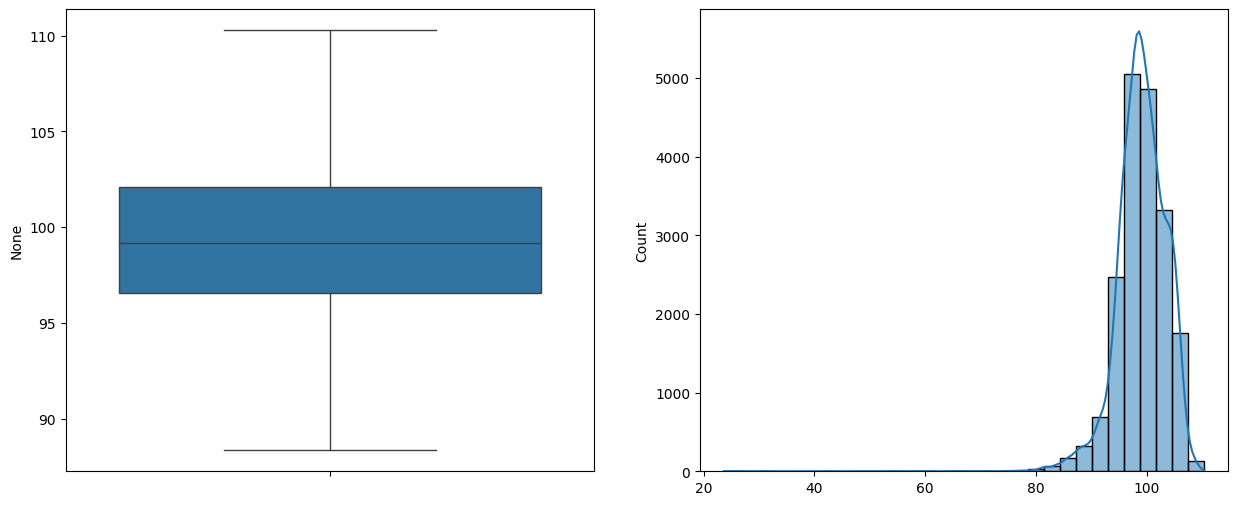

In [107]:
# plot distribution and box plot of MPI values
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(y=mpi_values, showfliers=False, ax=ax[0])
sns.histplot(mpi_values, bins=30, kde=True, ax=ax[1])

/tmp/ipykernel_34583/802258020.py:5: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  cities_boundaries.plot(column='nm_municipio', ax=ax, legend=False,


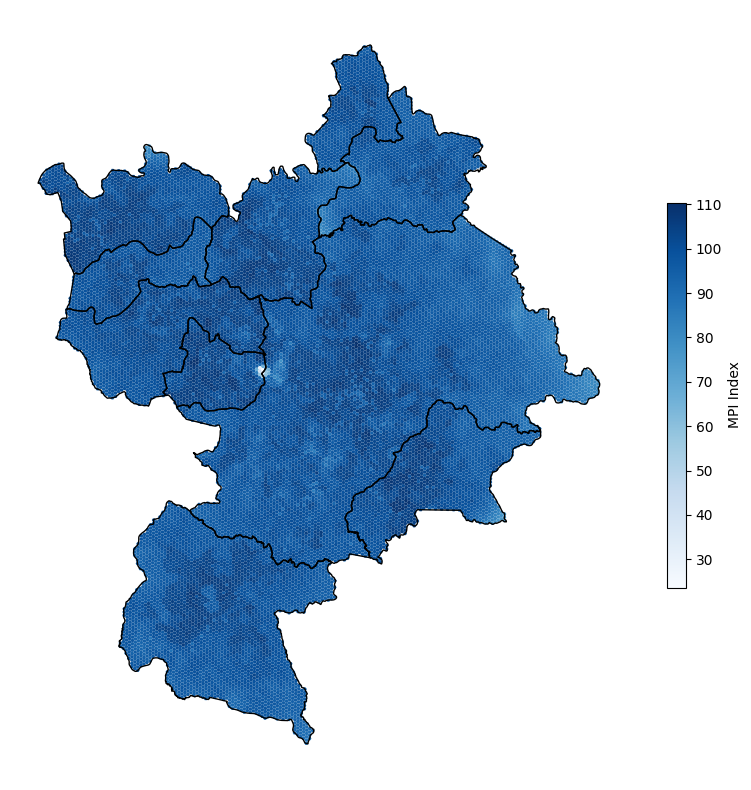

In [108]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
h3_index.plot(column='mpi_idx_all_features', ax=ax, legend=True, cmap='Blues',
              legend_kwds={'shrink': 0.5, 'label': 'MPI Index'})

cities_boundaries.plot(column='nm_municipio', ax=ax, legend=False,
                       color='none',
                       linewidth=1, edgecolor='black')

ax.set_axis_off()

## MPI calculated for each city

In [109]:
dict_df = {}

for city in h3_index['nm_city'].unique().tolist():
    h3_mpi_city = h3_index.query(f"nm_city == '{city}'")[MPI_columns]

    # Compute MPI for h3_mpi
    mpi_values, standardized_data = compute_mpi(h3_mpi_city, polarity)

    df = pd.DataFrame({'h3_index': h3_index.query(f"nm_city == '{city}'")['h3_index'],
                       'nm_city': city,
                       'mpi_idx_all_features_per_city': mpi_values})
    
    dict_df[city] = df

# concatenate all dataframes in dict_df
mpi_df = pd.concat(dict_df.values(), ignore_index=True)

# merge the MPI values with the h3_index DataFrame
h3_index = h3_index.merge(mpi_df, on=['h3_index', 'nm_city'], how='left')

# create a column with the flag above 100 per indicator after MPI
h3_index['mpi_flag_all_features_per_city'] = np.where(h3_index['mpi_idx_all_features_per_city'] >= 100, 'Above 100 - better locations',
                                            np.where(h3_index['mpi_idx_all_features_per_city'] < 100, 'Below 100 - worse locations',
                                                'No data'))

h3_index.head(3)

h3_index  h3_resolution     nm_city nm_state_abbrev  \
0  89a81140003ffff              9  indaiatuba              SP   
1  89a81140007ffff              9  indaiatuba              SP   
2  89a8114000bffff              9  indaiatuba              SP   

   nr_distance_urban_growth_2020_2022_m  nr_distance_road_m  \
0                                 517.0                 0.0   
1                                 252.0                 0.0   
2                                 503.0                 0.0   

   nr_distance_highways_m  nr_distance_urban_area_m  nr_poi_positive  \
0                   20298                       0.0               32   
1                   20465                       0.0               24   
2                   19947                       0.0               30   

   nr_poi_negative  fl_construction_restriction  nr_population_ibge22  \
0                2                            0                 648.0   
1                1                            0                 790.0   
2                0                            0                 761.0   

   nr_households_ibge22  rt_people_households_ibge22  \
0                 296.0                     2.189189   
1                 276.0                     2.862319   
2                 360.0                     2.113889   

   nr_monthly_income_household  nr_minimum_wage_household  \
0                      8041.04                       5.69   
1                     10893.25                       7.71   
2                      8690.00                       6.15   

  ds_minimum_wage_range_household  nr_poor_urban_communities  \
0    3. more than 5 minimum wages                          0   
1    3. more than 5 minimum wages                          0   
2    3. more than 5 minimum wages                          0   

   fl_contaminated_area  nr_contaminated_areas  nr_slope  \
0                     0                      0      23.0   
1                     0                      0      17.0   
2                     1                      1       5.0   

                                            geometry  mpi_idx_all_features  \
0  POLYGON ((-47.21295 -23.08044, -47.21189 -23.0...             95.672566   
1  POLYGON ((-47.21595 -23.07875, -47.21489 -23.0...            101.796072   
2  POLYGON ((-47.20986 -23.07905, -47.20879 -23.0...             95.738735   

          mpi_flag_all_features  mpi_idx_all_features_per_city  \
0   Below 100 - worse locations                      93.314049   
1  Above 100 - better locations                     102.269300   
2   Below 100 - worse locations                      85.809540   

  mpi_flag_all_features_per_city  
0    Below 100 - worse locations  
1   Above 100 - better locations  
2    Below 100 - worse locations

In [110]:
# check the difference
h3_index[['mpi_idx_all_features', 'mpi_idx_all_features_per_city']].describe()

mpi_idx_all_features  mpi_idx_all_features_per_city
count          18905.000000                   18905.000000
mean              99.085280                      99.091097
std                4.485313                       4.784927
min               23.647854                     -70.577618
25%               96.588000                      96.563764
50%               99.167722                      99.154099
75%              102.077879                     102.119731
max              110.405990                     112.102600

<Axes: xlabel='mpi_idx_all_features', ylabel='Frequency'>

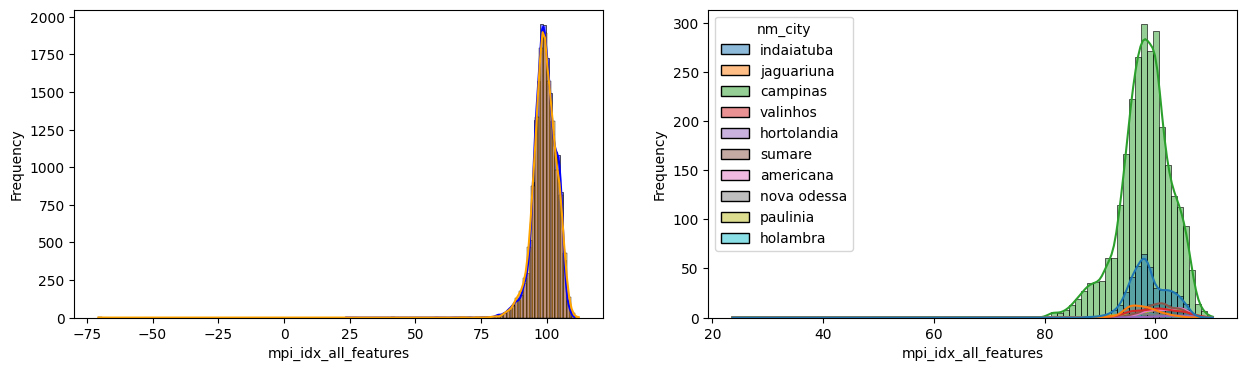

In [113]:
# plot the distribution of the mpi_idx and mpi_idx_new together
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(h3_index['mpi_idx_all_features'], bins=80, kde=True, label='mpi_idx',
             color='blue', stat='frequency', ax=ax[0])
sns.histplot(h3_index['mpi_idx_all_features_per_city'], bins=120, kde=True, label='mpi_idx_new',
             color='orange', stat='frequency', ax=ax[0])

# plot with city as hue
sns.histplot(h3_index, x='mpi_idx_all_features', hue='nm_city', bins=80,
             kde=True, stat='frequency', ax=ax[1])

City: indaiatuba


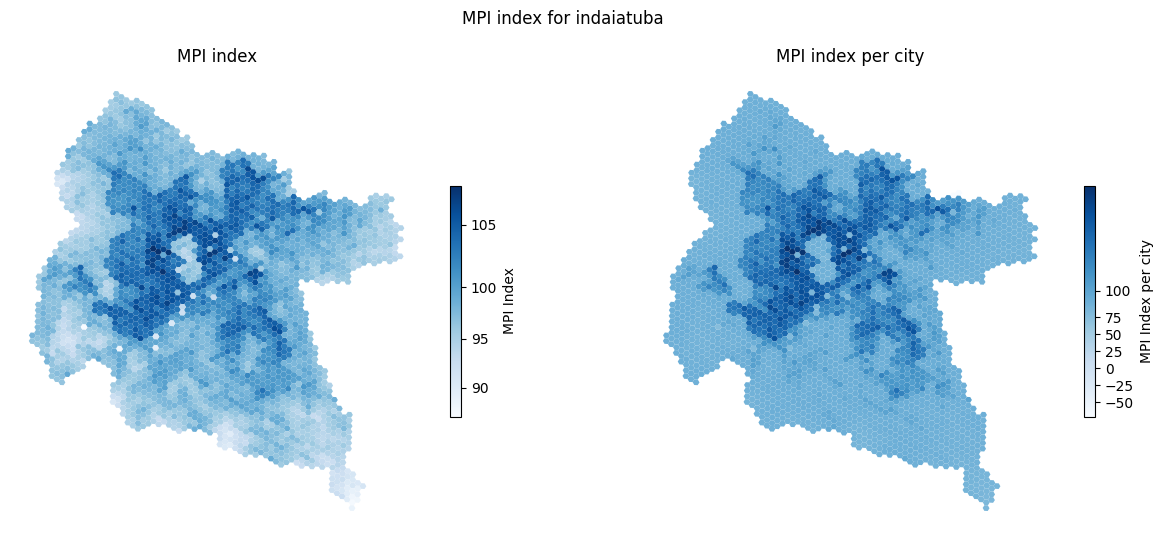

-------------------------------------
City: jaguariuna


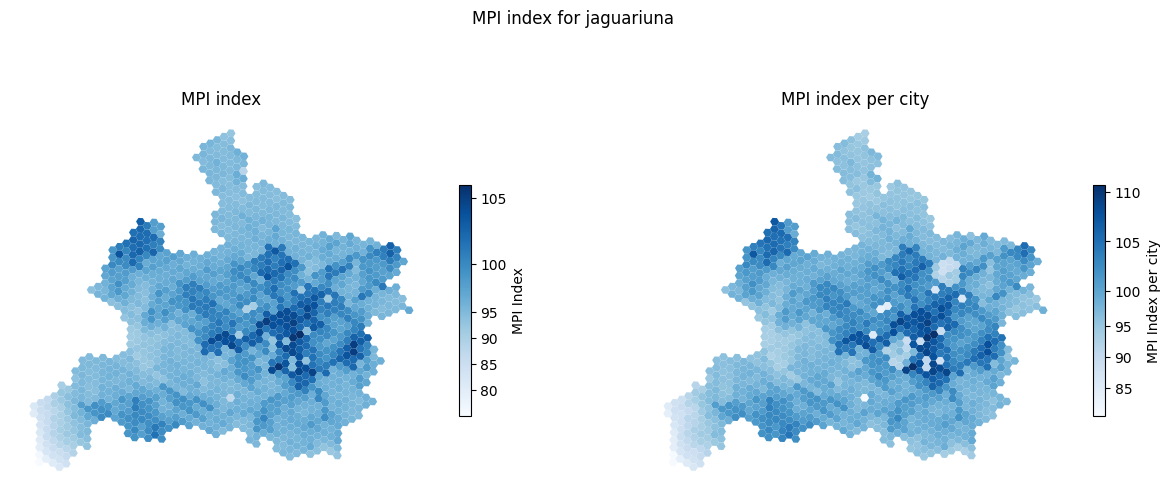

-------------------------------------
City: campinas


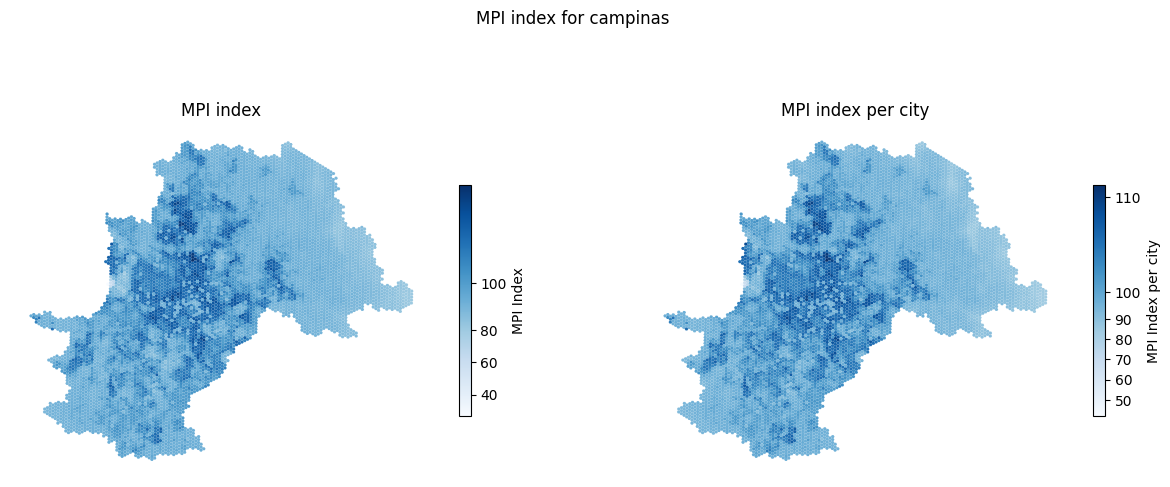

-------------------------------------
City: valinhos


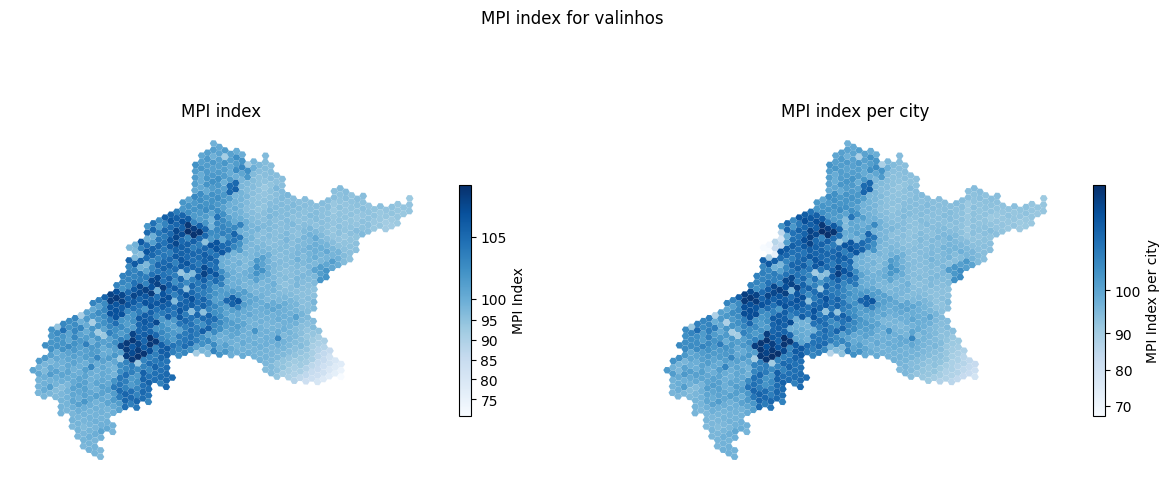

-------------------------------------
City: hortolandia


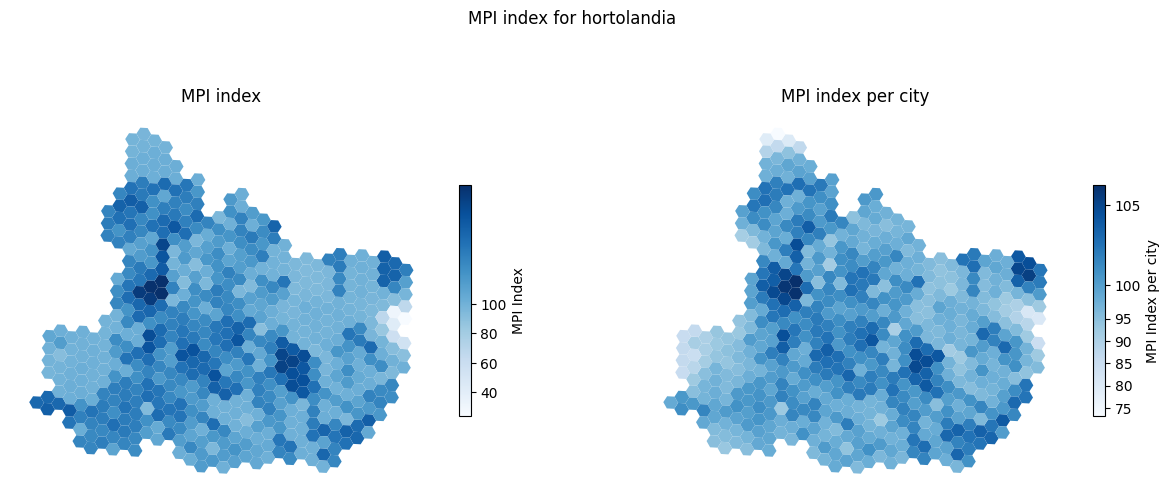

-------------------------------------
City: sumare


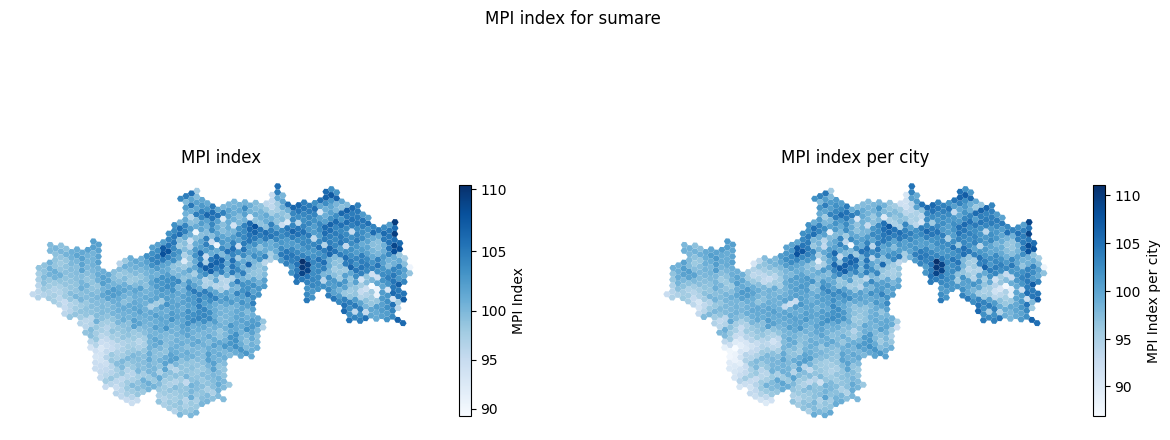

-------------------------------------
City: americana


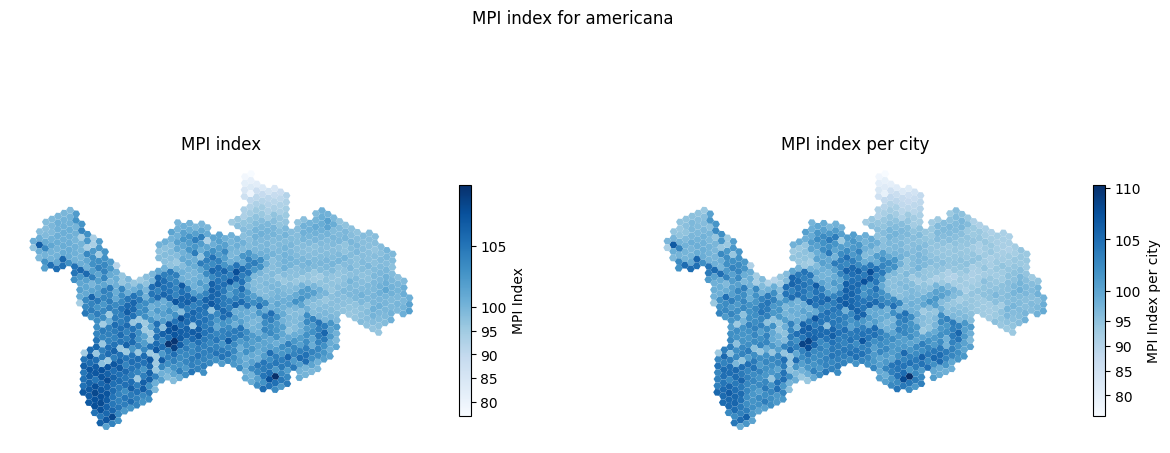

-------------------------------------
City: nova odessa


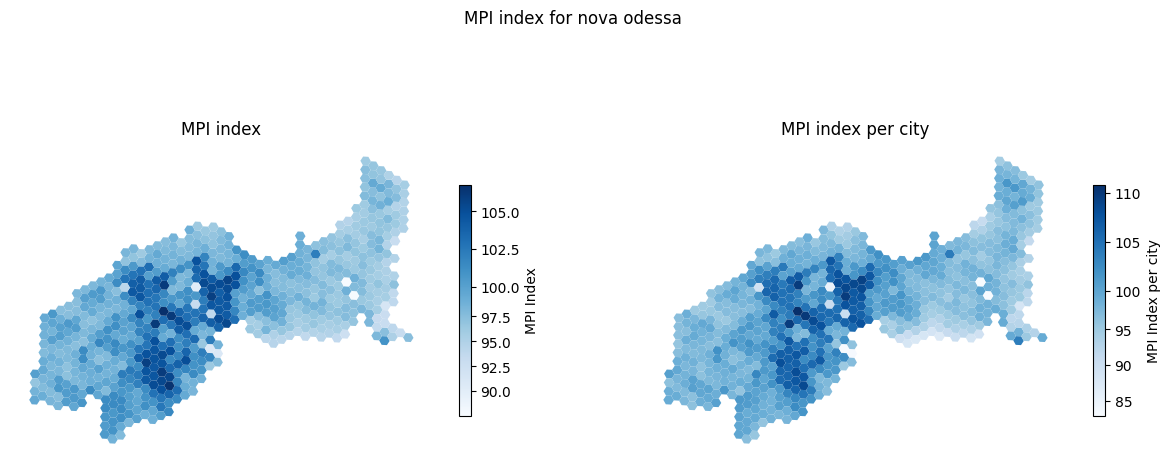

-------------------------------------
City: paulinia


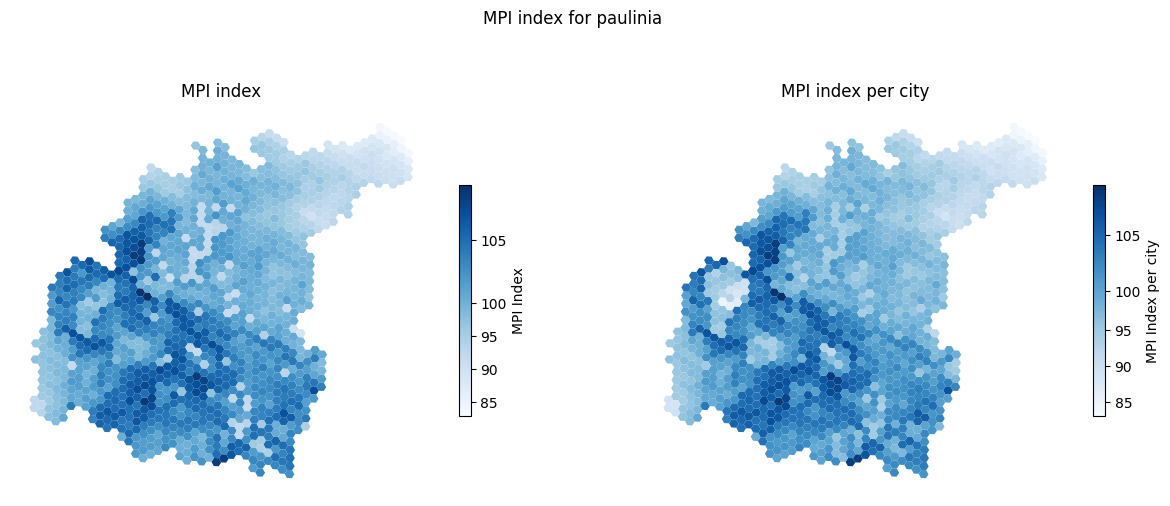

-------------------------------------
City: holambra


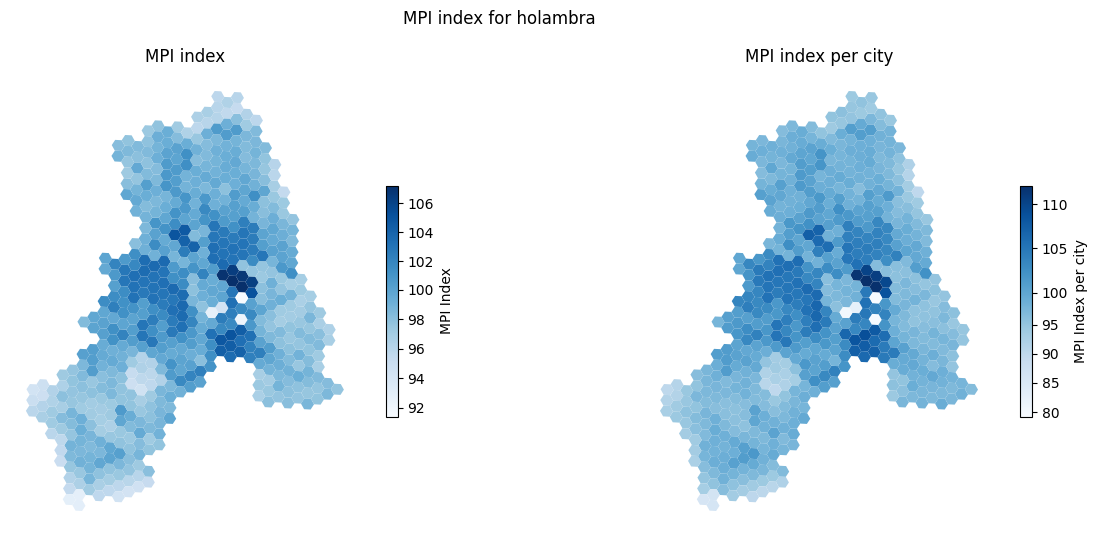

-------------------------------------


In [117]:
# plot the difference in a map

for city in h3_index['nm_city'].unique().tolist():
    print(f"City: {city}")
    df_city = h3_index.query(f"nm_city == '{city}'")
    fig, ax = plt.subplots(1,2, figsize=(15, 6))

    df = h3_index.query(f"nm_city == '{city}'")
    data_mean_mpi1 = df['mpi_idx_all_features'].mean()
    data_mean_mpi2 = df['mpi_idx_all_features_per_city'].mean()

    # Create a TwoSlopeNorm with the mean as the midpoint
    norm_mpi1 = TwoSlopeNorm(vmin=np.min(df['mpi_idx_all_features']), vcenter=data_mean_mpi1, vmax=np.max(df['mpi_idx_all_features']))
    norm_mpi2 = TwoSlopeNorm(vmin=np.min(df['mpi_idx_all_features_per_city']), vcenter=data_mean_mpi2, vmax=np.max(df['mpi_idx_all_features_per_city']))

    df.plot(column='mpi_idx_all_features',
                cmap='Blues',
                norm=norm_mpi1,
                legend=True,
                edgecolor='None',
                legend_kwds={'shrink': 0.5, 'label': 'MPI Index'},
                ax=ax[0])

    ax[0].set_title('MPI index')
    ax[0].set_axis_off()

    df.plot(column='mpi_idx_all_features_per_city',
                cmap='Blues',
                norm=norm_mpi2,
                legend=True,
                edgecolor='None',
                legend_kwds={'shrink': 0.5, 'label': 'MPI Index per city'},
                ax=ax[1])

    ax[1].set_title('MPI index per city')
    ax[1].set_axis_off()

    plt.suptitle(f'MPI index for {city}', fontsize=12)
    plt.show()
    print('-------------------------------------')

City: indaiatuba


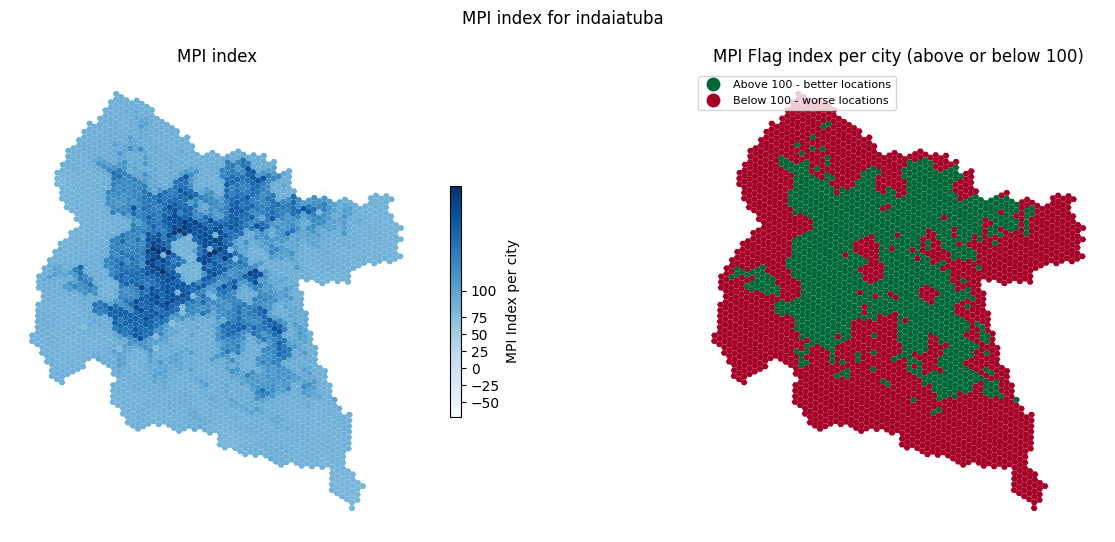

-------------------------------------
City: jaguariuna


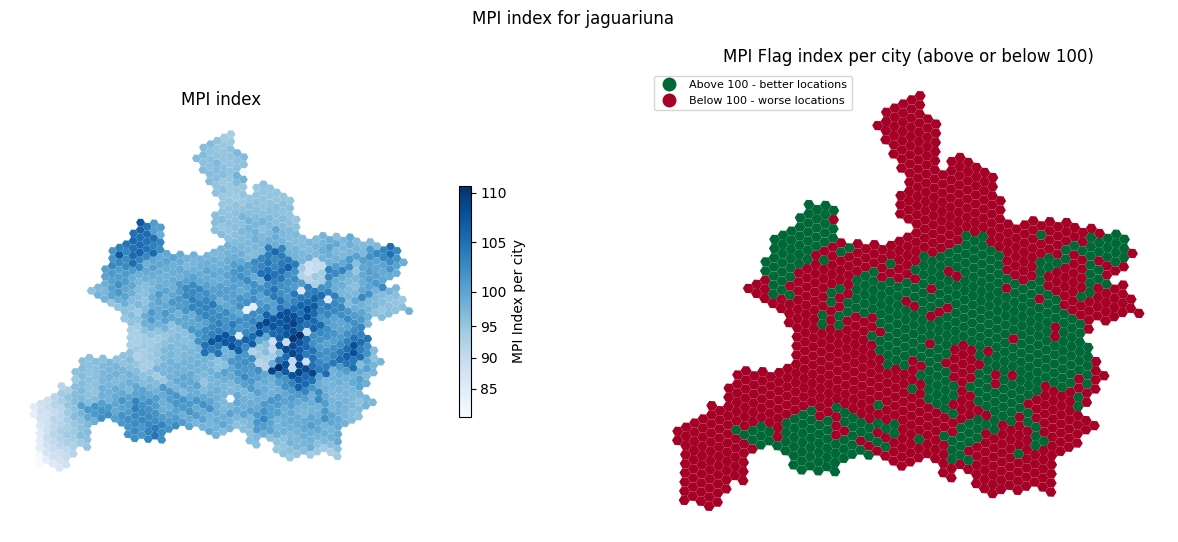

-------------------------------------
City: campinas


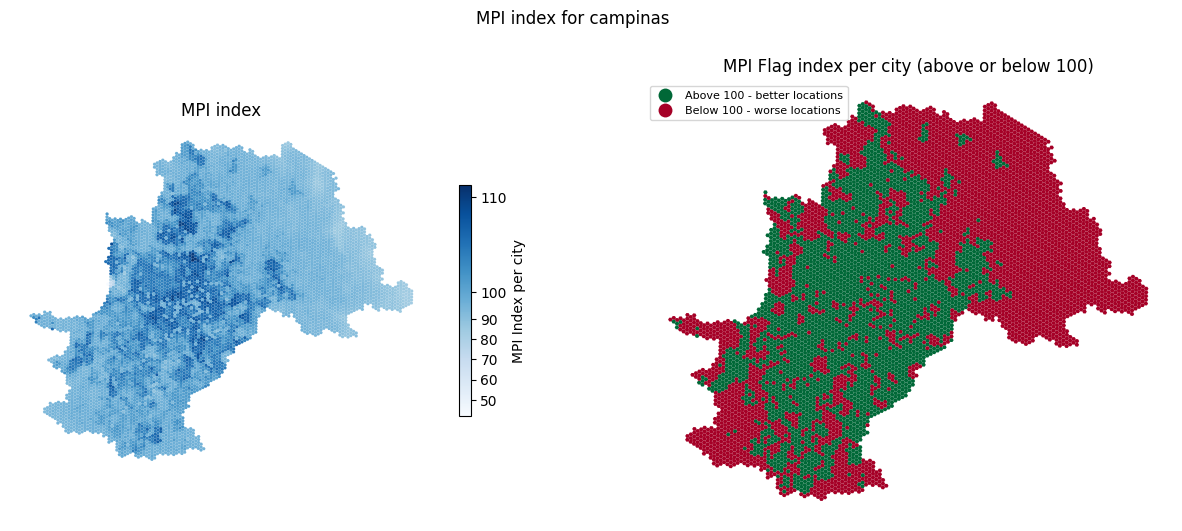

-------------------------------------
City: valinhos


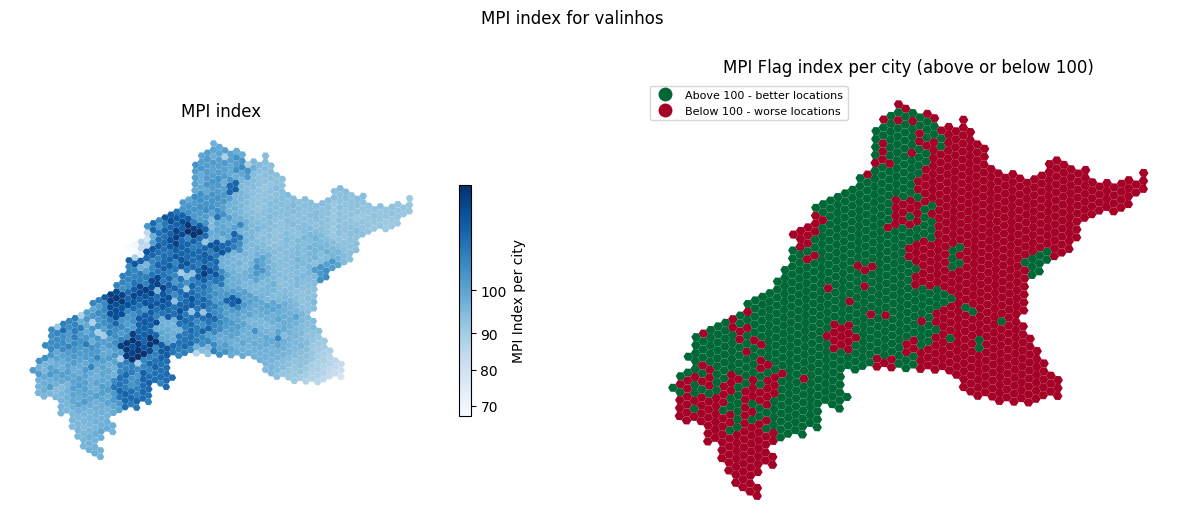

-------------------------------------
City: hortolandia


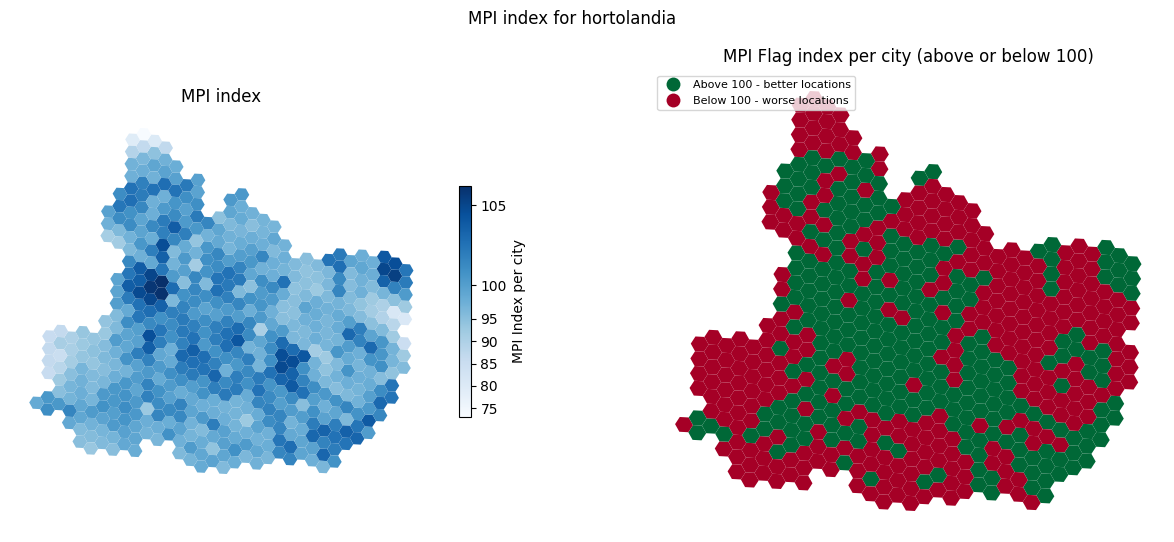

-------------------------------------
City: sumare


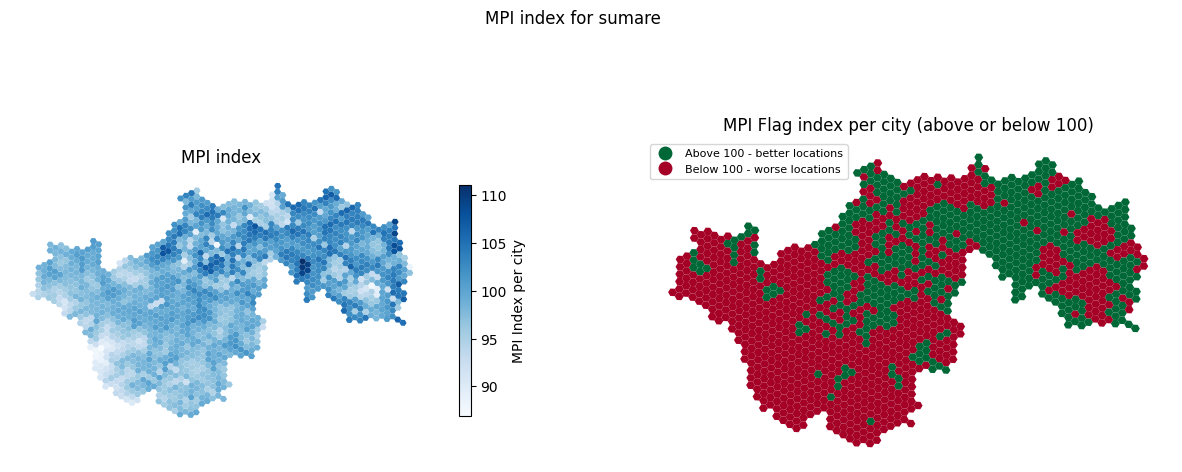

-------------------------------------
City: americana


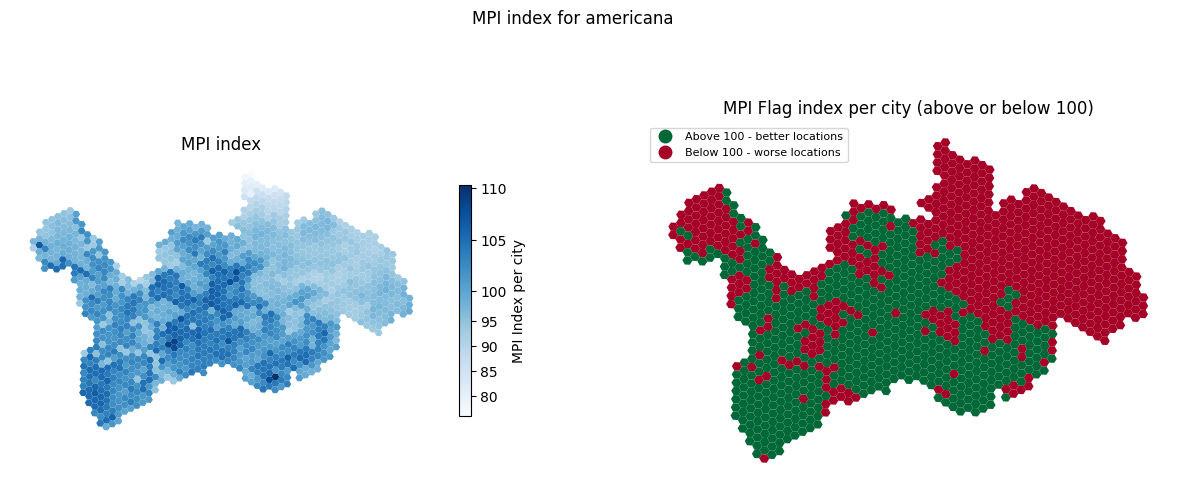

-------------------------------------
City: nova odessa


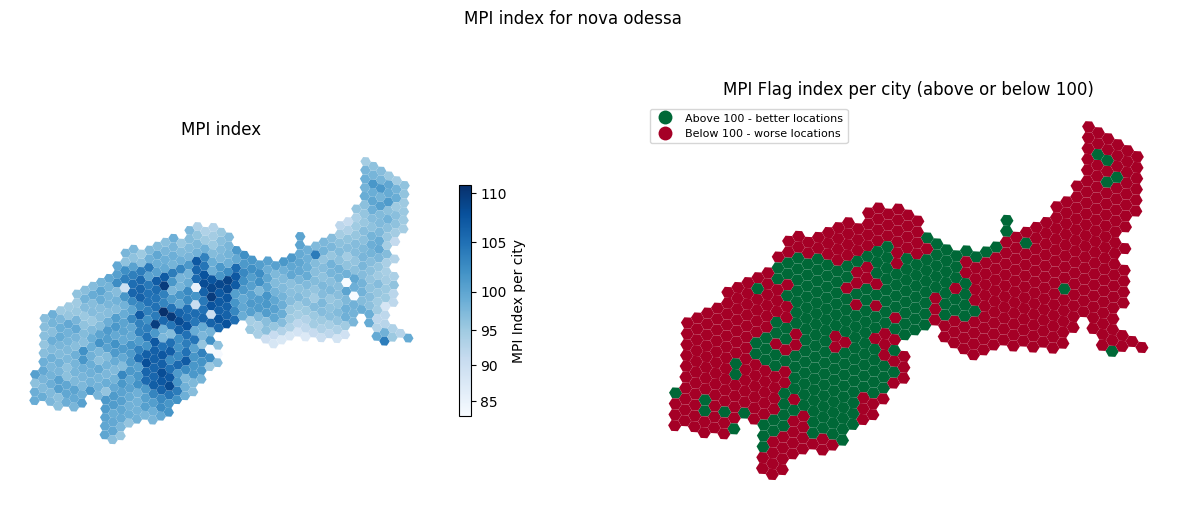

-------------------------------------
City: paulinia


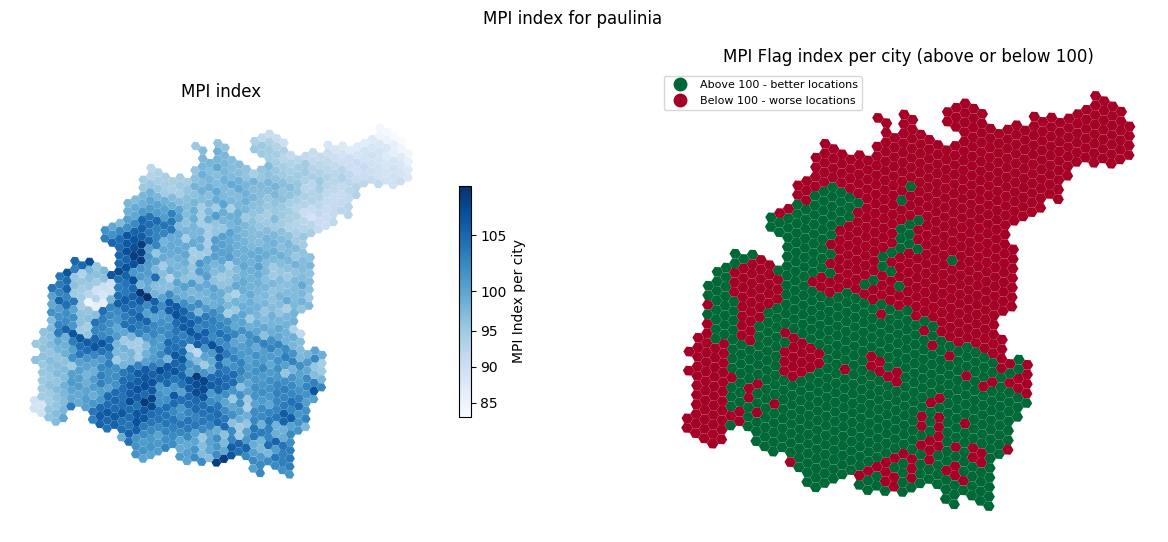

-------------------------------------
City: holambra


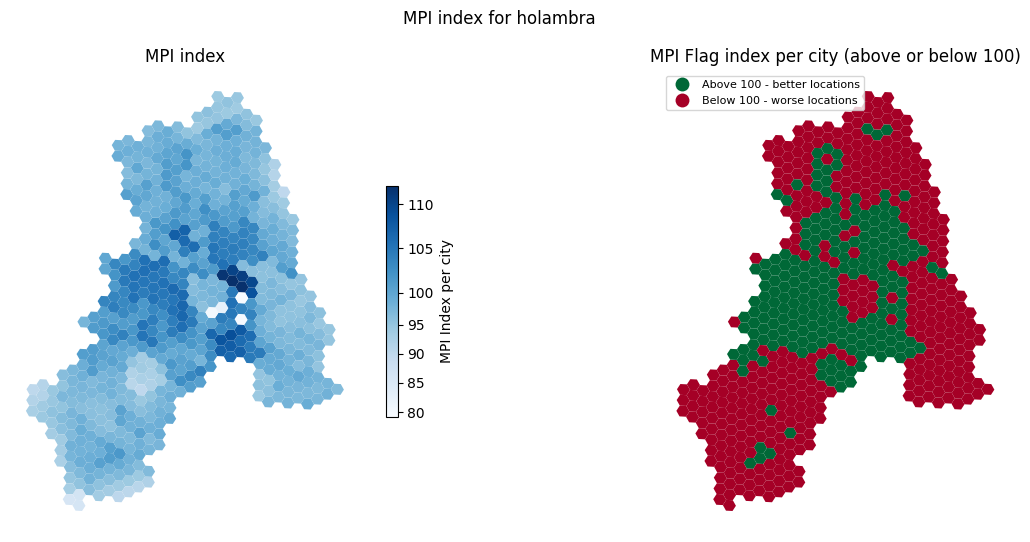

-------------------------------------


In [118]:
# plot the difference in a map

for city in h3_index['nm_city'].unique().tolist():
    print(f"City: {city}")
    df_city = h3_index.query(f"nm_city == '{city}'")
    fig, ax = plt.subplots(1,2, figsize=(15, 6))

    df = h3_index.query(f"nm_city == '{city}'")
    data_mean_mpi1 = df['mpi_idx_all_features_per_city'].mean()

    # Create a TwoSlopeNorm with the mean as the midpoint
    norm_mpi1 = TwoSlopeNorm(vmin=np.min(df['mpi_idx_all_features_per_city']), vcenter=data_mean_mpi1, vmax=np.max(df['mpi_idx_all_features_per_city']))

    df.plot(column='mpi_idx_all_features_per_city',
                cmap='Blues',
                norm=norm_mpi1,
                legend=True,
                edgecolor='None',
                legend_kwds={'shrink': 0.5, 'label': 'MPI Index per city'},
                ax=ax[0])

    ax[0].set_title('MPI index')
    ax[0].set_axis_off()

    df.plot(column='mpi_flag_all_features_per_city',
                cmap='RdYlGn_r',
                legend=True,
                edgecolor='None',
                legend_kwds={'loc': 'upper left', 'fontsize': 8},
                ax=ax[1])

    ax[1].set_title('MPI Flag index per city (above or below 100)')
    ax[1].set_axis_off()

    plt.suptitle(f'MPI index for {city}', fontsize=12)
    plt.show()
    print('-------------------------------------')

In [119]:
# save the h3_index with the new columns
h3_index.to_file(f'{LOCAL_FILE_PATH}h3_index_with_mpi.gpkg', driver='GPKG')